# Sentiment Analysis of Yelp! Reviews

### Background

Sentiment analysis can be used by companies to detect and understand customer feelings. The insight that sentiment analysis provides allows for a deeper understanding into customer experiences and can support a company's efforts to improve customer relationships and brand image.

For example, detecting an agitated customer's emotional state through support request emails or chat messages may prompt a customer service representative to directly contact the customer in order to resolve the issue. Furthermore, insight into a customer's negative emotional state may better prepare a customer service representative to deliver a more empathetic reposnse, ultimately contributing to improved customer relationships. Sentiment analysis can also be used in brand management for social media or review sites. Understanding customer sentiment in these domains is especially important given that shared online experiences can positively or negatively influence brand perception for other potential customers.

Additionally, insight into customer sentiment can assist with the evaluation of a company's investment potential. Private Equity firms can use sentiment analysis to gain a deeper understanding into a company's intangible assets such as its brand reputation and customer loyalty. Ultimately, the insights derived from sentiment analysis can lead to more informed investment decisions.

The aim of this project is to collect and analyze review data from Yelp! to derive insight into customer sentiment towards **Fast Casual Restaurants** in **Atlanta, Georgia**. 


### Project Structure

1. Importing Libraries
2. Scraping Data from Yelp!
3. Preprocessing Review Data
4. Performing Sentiment Analysis

## Part 1. Importing Libraries

In [2]:
# For Data Manipulation
import pandas as pd
import numpy as np

# For Web Scraping
from bs4 import BeautifulSoup
import requests
import time
import random

# For Sentiment Analysis
import nltk
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('omw-1.4')
from nltk.corpus import stopwords
from textblob import Word
from textblob import TextBlob
import scipy.stats as stats

# For Plotting
import matplotlib.pyplot as plt
import seaborn as sns

## Part 2. Scraping Data from Yelp!

To begin, we collect html data from Yelp! using web scraping tools with "fast casual restaurants" and "atlanta, ga" as paramaters. The output of the below code shows an excerpt of the raw html data we've collected.

### Important Limitation

While collecting review data via web scraping, it is likely that Yelp! blocks access to their website due to repetitive webpage requests. For this project, adding a variable time delay in scraping functions and using a VPN resolved this issue. Legal and ethical web scraping methods should be investigated further in order to effectively collect review data from Yelp! at scale.

In [3]:
url_command = 'http://yelp.com/search'
url_args = {'find_desc': "fast casual restaurants",
            'find_loc': "atlanta, ga"}
response = requests.get (url_command, params=url_args)

print ("==> Downloading from: '%s'" % response.url) # confirm URL
#print ("\n==> Excerpt from this URL:\n\n%s\n" % response.text[0:1000])

==> Downloading from: 'https://www.yelp.com/search?find_desc=fast+casual+restaurants&find_loc=atlanta%2C+ga'


### Obtaining Restaurant Names and Yelp! page links

Next, we collect the names and url links for the top 10 fast casual restaurants in Atlanta, GA from the above raw html data.

We do this by utilizing an html scraping package, BeautifulSoup, to look for links within the webpage that are associated with a business and extract the url's and business names.

In [3]:
restaurant_links = {}

soup = BeautifulSoup(response.content,'lxml')

for a in soup.find_all('a', class_ = 'css-1m051bw'):
    href = a.get('href')
    if (href[0:5] =="/biz/"):
        restaurant_links[a.get('name')] = a.get('href')

print(list(restaurant_links.keys()))

['gusto! Peachtree', 'Bantam + Biddy', 'Sahara Cafe', 'Karv Kitchen', 'Xi’an Gourmet House', 'Velvet Taco', 'PONKO Chicken', 'Rock’s Chicken & Fries', 'Local Expedition Wood Fired Grill', 'Aviva by Kameel - Atlanta']


In [4]:
df_links = pd.DataFrame.from_dict(restaurant_links, orient='index')\
            .reset_index().rename(columns={"index": "Name", 0: "Link"})

print('Top 10 Fast Casual Restaurants in Atlanta, GA:')
display(df_links)

Top 10 Fast Casual Restaurants in Atlanta, GA:


,Name,Link
0,gusto! Peachtree,/biz/gusto-peachtree-atlanta?osq=fast+casual+r...
1,Bantam + Biddy,/biz/bantam-biddy-atlanta?osq=fast+casual+rest...
2,Sahara Cafe,/biz/sahara-cafe-atlanta?osq=fast+casual+resta...
3,Karv Kitchen,/biz/karv-kitchen-chamblee-2?osq=fast+casual+r...
4,Xi’an Gourmet House,/biz/xi-an-gourmet-house-atlanta?osq=fast+casu...
5,Velvet Taco,/biz/velvet-taco-atlanta-2?osq=fast+casual+res...
6,PONKO Chicken,/biz/ponko-chicken-atlanta-2?osq=fast+casual+r...
7,Rock’s Chicken & Fries,/biz/rocks-chicken-and-fries-atlanta?osq=fast+...
8,Local Expedition Wood Fired Grill,/biz/local-expedition-wood-fired-grill-sandy-s...
9,Aviva by Kameel - Atlanta,/biz/aviva-by-kameel-atlanta-atlanta?osq=fast+...


To demonstrate the individual steps involved in collecting, preprocessing and analyzing review data, we will focus only on one restaurant: **'gusto! Peachtree'**.

### Obtaining Review Data

Using the link from **'gusto! Peachtree'**, we collect text data for 493 customer reviews.

Similar to the method used in the previous step, we identify the div's within a restaurant's individual Yelp! page that contain customers' reviews to extract the text data.

Because only 10 reviews are listed per page, we cycle through 50 pages in order to collect data all reviews.

In [5]:
reviews = []
for i in range(0,50):
    
    # adding variable time delay
    time.sleep(random.randint(1,5))
    
    # setting base url
    link = str(df_links['Link'][0])
    url = str('https://www.yelp.com') + link + str('&start=')

    if i == 0:
        r = requests.get(url + str(1))
        soup = BeautifulSoup(r.text, "html.parser")
        divs = soup.findAll(class_="review__09f24__oHr9V border-color--default__09f24__NPAKY")
        for div in divs:
            reviews.append(div.find('p').text)
    else:
        r = requests.get(url + str(i*10))
        soup = BeautifulSoup(r.text, "html.parser")
        divs = soup.findAll(class_="review__09f24__oHr9V border-color--default__09f24__NPAKY")
        for div in divs:
            reviews.append(div.find('p').text)
    
print('Number of Reviews Collected: ' + str(len(reviews)))

Number of Reviews Collected: 493


## Part 3. Preprocessing Review Data

The collected review data is then converted from a list into a pandas dataframe.

Word count, character count, average word length metrics are created for each review and added as columns in the dataframe.

In [6]:
df = pd.DataFrame(np.array(reviews), columns=['review'])

In [7]:
# Creating Word and Character Count metrics for each review
df['word_count'] = df['review'].apply(lambda x: len(x.split()))
df['character_count'] = df['review'].apply(lambda x: len(x))
df.head()

# Defining Average Word Length function
def avg_word_length(x):
    all_words = x.split()
    return round(sum(len(word) for word in all_words) / (len(all_words)),2)

# Creating Average Word Length metric
df['avg_word_length'] = df['review'].apply(lambda x: avg_word_length(x))

#### Stop Words
Stop words are words that are filtered out before processing natural language data. These words are insignificant in determining the sentiment in a review. The total number of stop words in each review as well as its percentage of the total word count are calculated.

Below are examples of excluded stop words...

In [8]:
stop_words = stopwords.words('english')
print('List of stop words includes:')
print(stop_words[0:10])

List of stop words includes:
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [9]:
df['stopword_count'] = df['review'].apply(lambda x: len([word for word in x.split() if word.lower() in stop_words]))
df['stopword_rate'] = round(df['stopword_count'] / df['word_count'], 2)
df.sort_values(by='stopword_rate')

,review,word_count,character_count,avg_word_length,stopword_count,stopword_rate
373,Awesome food! Kind of chipotle style idea- sup...,9,53,5.00,1,0.11
403,"Love this place !! Fresh food , fast service ,...",16,90,4.69,2,0.12
364,Wonderful food. Many combinations. Inexpensive...,12,90,6.58,2,0.17
393,"Fresh, fast, very tasty. Minimalist decor and ...",16,109,5.88,3,0.19
436,Fast healthy delicious clean. Affordable. Well...,16,100,5.31,3,0.19
...,...,...,...,...,...,...
298,This place is right across the street from Pie...,57,284,3.98,33,0.58
11,I was at the hospital with my wife and we deci...,73,395,4.42,42,0.58
395,Super delicious! All the people are very excel...,59,332,4.64,35,0.59
51,So fresh and at such a great value. Very delic...,64,311,3.88,39,0.61


In [10]:
df.describe()

,word_count,character_count,avg_word_length,stopword_count,stopword_rate
count,493.000000,493.000000,493.000000,493.000000,493.000000
mean,89.827586,500.219067,4.625578,40.137931,0.429817
std,92.794908,521.977023,0.425961,42.160375,0.078503
min,7.000000,49.000000,3.550000,1.000000,0.110000
25%,34.000000,191.000000,4.370000,13.000000,0.390000
50%,60.000000,324.000000,4.580000,28.000000,0.440000
75%,104.000000,577.000000,4.840000,48.000000,0.480000
max,772.000000,4642.000000,6.580000,340.000000,0.640000


#### Additional Data Transformations

Review data is made lowercase, and punctuation and stop words are removed.

In [11]:
# Making reviews lowercase
df['lowercase'] = df['review'].apply(lambda x: " ".join(word.lower() for word in x.split()))

# Removing punctuation (replacing any non letter or whitespace with '')
df['punctuation'] = df['lowercase'].str.replace('[^\w\s]','', regex=True)

# Removing stop words
df['stopwords'] = df['punctuation'].apply(lambda x: " ".join(word for word in x.split() if word not in stop_words))

#### Looking for additional stop words to exclude

A frequency test for all words in the reviews is performed to look for additional insignificant words to remove. These words are appended to the *stop_words* list and are removed from the review data.

The total number of remaining, 'clean words' in each review and its percentage of the total word count are calculated.

In [12]:
# Running frequency test on top 60 words in reviews
pd.Series(" ".join(df['stopwords']).split()).value_counts()[:60]

food          340
gusto         337
chipotle      283
chicken       276
place         248
good          223
sweet         214
great         212
rice          184
fresh         173
bowl          172
mango         161
like          160
healthy       160
avocado       157
chips         150
really        148
delicious     144
potato        143
fast          137
time          135
get           135
also          122
service       121
love          119
back          119
one           119
shrimp        117
sauce         114
meal          107
would         104
options       102
flavor        101
quick         100
order         100
go             99
try            98
salad          97
flavors        93
lunch          93
parking        92
im             90
menu           88
staff          87
well           86
greens         85
first          84
restaurant     82
nice           81
protein        80
friendly       78
brown          77
got            74
dont           73
choose         72
half      

In [13]:
# Removing other stop words that likely aren't contributing to meaning
stop_words.append(['one','get','also','go','ive','im','got'])

# Removing stop words
df['cleanreview'] = df['stopwords'].apply(lambda x: " ".join(word for word in x.split() if word not in stop_words))

# Calculating Clean word count and percentage
df['clean_review_word_count'] = df['cleanreview'].apply(lambda x: len(x.split()))
df['clean_rate'] = round(df['clean_review_word_count'] / df['word_count'],2)

#### Lemmatization

Lemmatization considers context and converts each word in the review to its meaningful base form.

For example, **'runs'**,**'running'**,and **'ran'** would be converted to **'run'**

In [14]:
# Lemmatized review data is created
df['lemmatized'] = df['cleanreview'].apply(lambda x: " ".join(Word(word).lemmatize() for word in x.split()))

# Preview of dataset
df.head()

,review,word_count,character_count,avg_word_length,stopword_count,stopword_rate,lowercase,punctuation,stopwords,cleanreview,clean_review_word_count,clean_rate,lemmatized
0,This spot is absolutely delicious with probabl...,84,472,4.63,38,0.45,this spot is absolutely delicious with probabl...,this spot is absolutely delicious with probabl...,spot absolutely delicious probably best bowls ...,spot absolutely delicious probably best bowls ...,45,0.54,spot absolutely delicious probably best bowl i...
1,"I love Gusto so much, but this is the THIRD ti...",140,786,4.62,69,0.49,"i love gusto so much, but this is the third ti...",i love gusto so much but this is the third tim...,love gusto much third time ive ordered locatio...,love gusto much third time ive ordered locatio...,71,0.51,love gusto much third time ive ordered locatio...
2,I've always gotten Gusto catered through my wo...,59,313,4.32,31,0.53,i've always gotten gusto catered through my wo...,ive always gotten gusto catered through my wor...,ive always gotten gusto catered work much bett...,ive always gotten gusto catered work much bett...,28,0.47,ive always gotten gusto catered work much bett...
3,We need one in my town - I like to try differe...,175,858,3.90,78,0.45,we need one in my town - i like to try differe...,we need one in my town i like to try differen...,need one town like try different food options ...,need one town like try different food options ...,88,0.50,need one town like try different food option a...
4,Meals have favor and good portions. Venue is c...,18,109,5.11,7,0.39,meals have favor and good portions. venue is c...,meals have favor and good portions venue is cl...,meals favor good portions venue clean staff pr...,meals favor good portions venue clean staff pr...,10,0.56,meal favor good portion venue clean staff prof...


## Part 4. Sentiment Analysis

Using the TextBlob package to perform sentiment analysis and to create polarity and subjectivity measures.

**Polarity** refers to how positive or negative a statement is and scores range from **-1** (negative) to **1** (positive).

**Subjectivity** scores range from **0** (factual information) to **1** (personal opinion, emotion or judgment).

See the polarity and subjectivity scores for the following sample sentences...

In [15]:
TextBlob("This restaurant is wonderful!").sentiment

Sentiment(polarity=1.0, subjectivity=1.0)

In [16]:
TextBlob("This restaurant is awful.").sentiment

Sentiment(polarity=-1.0, subjectivity=1.0)

In [17]:
TextBlob("This restaurant has 20 items on the menu.").sentiment

Sentiment(polarity=0.0, subjectivity=0.0)

In [18]:
TextBlob("This restaurant has its strengths and weaknesses. Overall, a good lunch spot.").sentiment

Sentiment(polarity=0.35, subjectivity=0.30000000000000004)

#### Creating Polarity and Subjectivity scores for review data

In [19]:
# Creating Polarity and Subjectivity metrics
df['polarity'] = df['lemmatized'].apply(lambda x: TextBlob(x).sentiment[0])
df['subjectivity'] = df['lemmatized'].apply(lambda x: TextBlob(x).sentiment[1])

# Dropping Unnecessary columns
df.drop(['lowercase','punctuation','stopwords','cleanreview','lemmatized'], axis=1, inplace=True)

# Previewing data
df.head()

,review,word_count,character_count,avg_word_length,stopword_count,stopword_rate,clean_review_word_count,clean_rate,polarity,subjectivity
0,This spot is absolutely delicious with probabl...,84,472,4.63,38,0.45,45,0.54,0.230833,0.549167
1,"I love Gusto so much, but this is the THIRD ti...",140,786,4.62,69,0.49,71,0.51,0.234375,0.600000
2,I've always gotten Gusto catered through my wo...,59,313,4.32,31,0.53,28,0.47,0.300000,0.450000
3,We need one in my town - I like to try differe...,175,858,3.90,78,0.45,88,0.50,0.145536,0.528571
4,Meals have favor and good portions. Venue is c...,18,109,5.11,7,0.39,10,0.56,0.388889,0.466667


In [20]:
# Describing the data
df.describe()

,word_count,character_count,avg_word_length,stopword_count,stopword_rate,clean_review_word_count,clean_rate,polarity,subjectivity
count,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000
mean,89.827586,500.219067,4.625578,40.137931,0.429817,48.549696,0.557120,0.275965,0.606750
std,92.794908,521.977023,0.425961,42.160375,0.078503,50.195675,0.076084,0.183331,0.119609
min,7.000000,49.000000,3.550000,1.000000,0.110000,5.000000,0.360000,-0.248000,0.000000
25%,34.000000,191.000000,4.370000,13.000000,0.390000,19.000000,0.510000,0.147865,0.533333
50%,60.000000,324.000000,4.580000,28.000000,0.440000,32.000000,0.550000,0.261270,0.600000
75%,104.000000,577.000000,4.840000,48.000000,0.480000,57.000000,0.590000,0.395833,0.669444
max,772.000000,4642.000000,6.580000,340.000000,0.640000,473.000000,0.890000,0.866667,1.000000


#### One-sample t-test

Using a one-sample t-test to investigate if the polarity scores for *gusto! Peachtree* is significantly different than **0** which would represent a completely neutral sentiment.

In [21]:
stats.ttest_1samp(df['polarity'], 0)

Ttest_1sampResult(statistic=33.4226505226652, pvalue=1.097340048624706e-128)

#### 2-D Histogram for Polarity and Subjectivity Scores

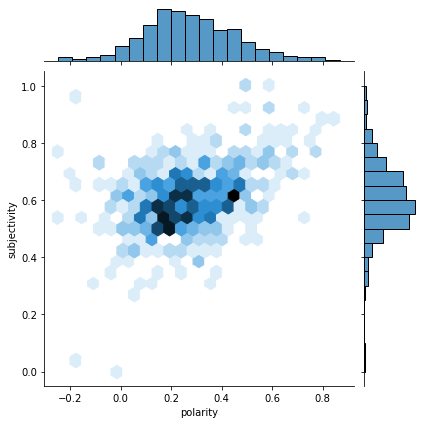

In [22]:
sns.jointplot(x=df["polarity"], y=df["subjectivity"], kind='hex', marginal_kws=dict(bins=20, fill=True))
plt.show()

### Findings & Interpretation for *gusto! Peachtree*

For the 463 reviews collected on *gusto! Peachtree* the mean word count for each review was 89.8, the mean character count was 500.2, and the average word length was 4.6. On average, roughly 43.0% of the words in each review were stop words and 55.7% were clean words contributing to sentiment scores. Finally, mean polarity and subjectivity scores were 0.28 and 0.61 respectively. Of note, the one-sample t-test did not reveal significant differences between the mean polarity score and 0, a completely neutral sentiment score. 

Despite polarity scores not appearing statistically significant, these findings suggest that the overall customer sentiment for *gusto! Peachtree* is mostly positive and reviews tend to be slightly more subjective in nature rather than objective. The positive polarity score is consistent with Yelp!'s ranking of *gusto! Peachtree* as the #1 fast-casual restaurant in Atlanta, GA. The subjectivity score can be interpreted as typical of review data which reflects customers' individual experiences and naturally favors subjectivity over objectivity.

#### Creating get_sentiment function

Next, we create a function, *get_sentiment*, which takes a restaurant's Yelp! url as an input and scrapes, preprocesses and analyzes review data ultimately generating polarity and subjectivity scores. As an example, we use this function to perform sentiment analysis for the #2 fast-casual restaurant, *Bantam + Biddy*.

In [23]:
def get_sentiment(link):
    
    url = str('https://www.yelp.com') + link + str('&start=')

    # Scraping Review Data -------------------------------------------------------
    
    reviews = []
    
    # Extracting Reviews for each page (10 reviews per page)
    for i in range(0,50):
        
        # adding variable time delay
        time.sleep(random.randint(1,5))
        
        if i == 0:
            r = requests.get(url + str(1))
            soup = BeautifulSoup(r.text, "html.parser")
            divs = soup.findAll(class_="review__09f24__oHr9V border-color--default__09f24__NPAKY")
            for div in divs:
                reviews.append(div.find('p').text)
        else:
            r = requests.get(url + str(i*10))
            soup = BeautifulSoup(r.text, "html.parser")
            divs = soup.findAll(class_="review__09f24__oHr9V border-color--default__09f24__NPAKY")
            for div in divs:
                reviews.append(div.find('p').text)
        
    # Pre-processing Review Data -------------------------------------------------------
    
    # Creating DataFrame from reviews list
    df = pd.DataFrame(np.array(reviews), columns=['review'])
        
    # Creating Word and Character Count metrics for each review
    df['word_count'] = df['review'].apply(lambda x: len(x.split()))
    df['character_count'] = df['review'].apply(lambda x: len(x))
    
    # Getting Average Word Length
    df['avg_word_length'] = df['review'].apply(lambda x: avg_word_length(x))
    
    # Getting Metrics on Stop Words
    df['stopword_count'] = df['review']\
    .apply(lambda x: len([word for word in x.split() if word.lower() in stop_words]))
    df['stopword_rate'] = round(df['stopword_count'] / df['word_count'], 2)
    
    # Making reviews lowercase
    df['lowercase'] = df['review'].apply(lambda x: " ".join(word.lower() for word in x.split()))
    
    # Removing punctuation (replacing any non letter or whitespace with '')
    df['punctuation'] = df['lowercase'].str.replace('[^\w\s]','', regex=True)
    
    # Selecting words in review that are not stop words
    df['cleanreview'] = df['punctuation']\
    .apply(lambda x: " ".join(word for word in x.split() if word not in stop_words))
    
    # Getting Clean Word Metrics
    df['clean_review_word_count'] = df['cleanreview'].apply(lambda x: len(x.split()))
    df['clean_rate'] = round(df['clean_review_word_count'] / df['word_count'],2)
    
    # Lemmatzing Words
    df['lemmatized'] = df['cleanreview'].apply(lambda x: " ".join(Word(word).lemmatize() for word in x.split()))
    
    # Sentiment Analysis -------------------------------------------------------
    
    # Getting Polarity and Subjectivity Metrics
    df['polarity'] = df['lemmatized'].apply(lambda x: TextBlob(x).sentiment[0])
    df['subjectivity'] = df['lemmatized'].apply(lambda x: TextBlob(x).sentiment[1])
    
    # Cleaning Final Dataset -------------------------------------------------------
    
    df.drop(['lowercase','punctuation','cleanreview','lemmatized'], axis=1, inplace=True)
    
    # 2-D Histogram for Polarity and Subjectivity Scores -------------------------------
    sns.jointplot(x=df["polarity"], y=df["subjectivity"], kind='hex', marginal_kws=dict(bins=20, fill=True))
    plt.show()
    
    return df.describe()

#### Sentiment Analysis for *Bantam + Biddy*

In [24]:
print('Restaurant Name: ' + str(df_links['Name'][1]))
print('Restaurant Link: ' + str(df_links['Link'][1]))

Restaurant Name: Bantam + Biddy
Restaurant Link: /biz/bantam-biddy-atlanta?osq=fast+casual+restaurants


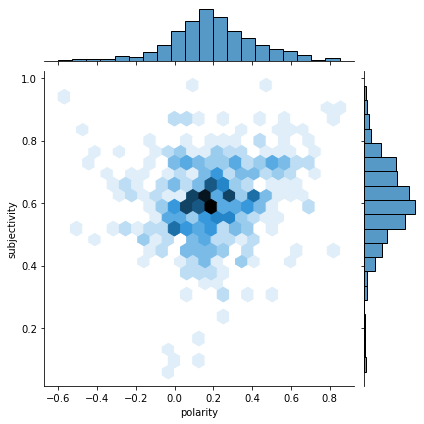

,word_count,character_count,avg_word_length,stopword_count,stopword_rate,clean_review_word_count,clean_rate,polarity,subjectivity
count,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000
mean,112.756522,619.826087,4.566000,51.854348,0.446152,59.215217,0.538413,0.198073,0.605482
std,108.721354,600.522598,0.406725,50.642092,0.068579,56.778738,0.066147,0.221082,0.128329
min,7.000000,47.000000,3.680000,1.000000,0.140000,6.000000,0.350000,-0.600000,0.061905
25%,40.000000,226.250000,4.327500,18.000000,0.410000,22.000000,0.500000,0.065804,0.533333
50%,80.000000,442.000000,4.495000,37.000000,0.460000,42.000000,0.530000,0.189365,0.605808
75%,141.000000,785.500000,4.752500,68.250000,0.490000,73.000000,0.570000,0.329297,0.685444
max,769.000000,4282.000000,6.860000,347.000000,0.620000,405.000000,0.860000,0.850000,0.975000


In [25]:
get_sentiment(df_links['Link'][1])

### Findings & Interpretation for *Bantam + Biddy*

Very similar to *gusto! Peachtree*, sentiment analysis for *Bantam + Biddy* suggests that the overall customer sentiment is mostly positive and reviews tend to be slightly more subjective in nature rather than objective. These findings are consistent with Yelp!'s ranking of *Bantam + Biddy* as the #2 fast-casual restaurant in Atlanta, GA.

## Final Thoughts

This project demonstrates a methodology for data collection, preprocessing, analysis, and visualization for sentiment analysis. Overall, the results from this project provide a snapshot of customer sentiment towards a fast casual restaurant by leveraging Yelp! review data. While these techniques effectively measure the polarity and subjectivity of customer reviews, additional natural language processing methods such as topic modelling and text summarization should be investigated in order to identify specific areas of improvement for each restaurant.